This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
from collections import Counter, defaultdict
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    save = False
    country_num = 10

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 27.6 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [ ]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
if CFG.debug:
    train = train[:10000]

In [ ]:
countries = train['country'].value_counts()
major_countries = countries[countries > CFG.country_num].index
major_countries

Index(['US', 'TR', 'ID', 'JP', 'TH', 'RU', 'BR', 'MY', 'BE', 'GB',
       ...
       'CM', 'AG', 'MW', 'VC', 'VA', 'RW', 'DM', 'CV', 'SX', 'CD'],
      dtype='object', length=176)

In [ ]:
mean_latlon = train[train['country'].isin(major_countries)].groupby('country')[['latitude', 'longitude']].mean().apply(lambda x: tuple(x), axis = 1).to_dict()
mean_latlon

{'AD': (42.545859185636466, 1.5623949169263895),
 'AE': (25.031196156825867, 55.125843416026626),
 'AF': (33.83802625734884, 66.24355789971725),
 'AG': (17.064483743894495, -61.8103130873108),
 'AL': (41.16438043034689, 19.412328749941274),
 'AM': (40.226330254579786, 44.639090877452354),
 'AO': (-8.889374849019317, 13.202976589291133),
 'AQ': (-69.60762211178053, -13.85584018293251),
 'AR': (-34.3017973185889, -59.675176940818325),
 'AT': (47.82784149912836, 14.668674401181589),
 'AU': (-33.60605387334255, 145.81505022396252),
 'AW': (12.538799105310463, -70.0247308418892),
 'AX': (59.189586941545805, 18.925737862902142),
 'AZ': (40.3754732198509, 49.74492239537704),
 'BA': (43.94847201899628, 18.204256543029196),
 'BB': (13.108549846295455, -59.59389100581457),
 'BD': (23.832095040888664, 89.78014903512299),
 'BE': (50.98628567649715, 4.058717644388699),
 'BG': (42.641392575674466, 24.688713330227394),
 'BH': (26.24331108929355, 50.43609293011559),
 'BL': (17.904371494236624, -62.841

In [ ]:
!pip install haversine
from haversine import haversine, Unit

In [ ]:
def correct_country(latlon):
    min_distance = float('inf')
    min_country = None
    for country in major_countries:
        distance = haversine(latlon, mean_latlon[country])
        if distance < min_distance:
            min_distance = distance
            min_country = country
    return min_country
train['new_country'] = train[['latitude', 'longitude']].apply(correct_country, axis = 1)
test['new_country'] = test[['latitude', 'longitude']].apply(correct_country, axis = 1)
print('Concordance rate: ' + str((train['country'] == train['new_country']).mean()))
train.head()

Concordance rate: 0.7032521610239443


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,new_country
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,BE
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,BR
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,TH
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,TR
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,ES


# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'new_country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("new_country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id,near_name,near_address,near_city,near_state,near_zip,near_new_country,near_url,near_phone,near_categories
0,E_0014dae22ccd6b,shôko restaurant,41.385287,2.197004,"pg. marítim de la barceloneta, 38",barcelona,nan,nan,ES,nan,...,E_0014dae22ccd6b,shôko restaurant,"pg. marítim de la barceloneta, 38",barcelona,nan,nan,ad,nan,nan,japanese restaurants


In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name,near_address,near_city,near_state,near_zip,near_new_country,near_url,near_phone,near_categories,target
363,E_1c42297fda9e48,beverage station,44.752732,-1.086829,nan,nan,nan,33510,FR,nan,...,the beverage station,nan,nan,nan,33510,ad,nan,nan,fast food restaurants,1
373,E_1d31342d2e5805,estación de servicio cepsa,43.284564,-2.265653,barrio narrondo,zumaia,gipuzkoa,20750,ES,https://cercadeti.cepsa.es/6114-estacion-de-se...,...,estación de servicio cepsa,barrio narrondo,zumaia,gipuzkoa,20750,ad,https://cercadeti.cepsa.es/530-estacion-de-ser...,+34943861082,nan,1
642,E_34e1bc94cd94d3,rent a car saint jean de luz,43.406270,-1.616368,zi de jalday,saint jean de luz,aquitaine-limousin-poitou-charentes,64500,FR,https://www.rentacar.fr/agences/391-saint-jean...,...,rent a car saint jean de luz,zi de jalday,saint jean de luz,nan,64500,ad,https://www.rentacar.fr/agences/391-saint-jean...,+33559507060,rental car locations,1
719,E_3bdf0c22354e57,taverna ongi etorriak,41.346620,1.696817,carrer sant bernat,vilafranca del penedes,barcelona,08720,ES,nan,...,ongi etorriak,"c. de sant bernat, 4",vilafranca del penedes,barcelona,08720,ad,nan,938904354,tapas restaurants,1
730,E_3cb8475424e07f,obaibi,43.607900,1.394600,36/54 rte de bayonne,toulouse,france,31 000,FR,nan,...,okaidi-obaibi,36/54 rte de bayonne,toulouse,france,31 000,ad,nan,nan,"kids stores, arcades",1


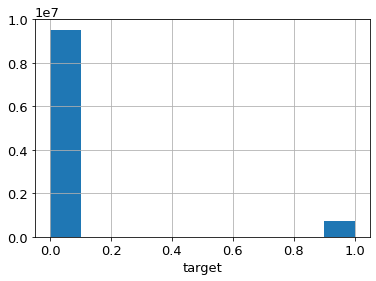

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.8929518335714638


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

     |████████████████████████████████| 258 kB 29.6 MB/s 
     |████████████████████████████████| 1.8 MB 53.9 MB/s 
     |████████████████████████████████| 103 kB 69.2 MB/s 


In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'new_country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['new_country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('new_country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
50768,E_02ef4d9ef8aa33,beach,17.085518,-61.893896,hermitage bay,st. john's,parish of saint john,nan,AG,nan,...,3,0.166667,15,0.30112,2,7,17,0.882353,0.117647,0.285714


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
4,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794374,nan,nan,nan,nan,ID,nan,...,3,0.695652,7,0.461111,8,8,15,0.466667,0.533333,1.0


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
train['id_pair'] = train[['id', 'near_id']].apply(lambda x: tuple(sorted(list(x))), axis = 1)
test['id_pair'] = test[['id', 'near_id']].apply(lambda x: tuple(sorted(list(x))), axis = 1)

In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'new_country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['new_country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_new_country_gesh', 'near_new_country_jaro', 'near_new_country_lcs', 'near_new_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categor

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id", "id_pair"]]
test = test[features + ["id", "near_id", "id_pair"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10250452 entries, 0 to 10250451
Data columns (total 60 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float

# Split Folds

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
distrs = [get_distribution(train["target"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train, train["target"], train["id_pair"], k=CFG.n_splits, seed=CFG.seed)):
    train.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train.loc[dev_ind, "target"], train.loc[val_ind, "target"]
    dev_groups, val_groups = train.loc[dev_ind, "id_pair"], train.loc[val_ind, "id_pair"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train["target"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.95%,7.05%
development set - fold 0,92.95%,7.05%
validation set - fold 0,92.95%,7.05%
development set - fold 1,92.95%,7.05%
validation set - fold 1,92.95%,7.05%
development set - fold 2,92.95%,7.05%
validation set - fold 2,92.95%,7.05%


# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.0857518
[100]	valid_0's binary_logloss: 0.0826716
[150]	valid_0's binary_logloss: 0.0812518
[200]	valid_0's binary_logloss: 0.0803249
[250]	valid_0's binary_logloss: 0.0796848
[300]	valid_0's binary_logloss: 0.078996
[350]	valid_0's binary_logloss: 0.0786018
[400]	valid_0's binary_logloss: 0.0782053
[450]	valid_0's binary_logloss: 0.0778982
[500]	valid_0's binary_logloss: 0.0775985
[550]	valid_0's binary_logloss: 0.0774384
[600]	valid_0's binary_logloss: 0.0772306
[650]	valid_0's binary_logloss: 0.0770298
[700]	valid_0's binary_logloss: 0.0768705
[750]	valid_0's binary_logloss: 0.0767189
[800]	valid_0's binary_logloss: 0.0766028
[850]	valid_0's binary_logloss: 0.0764501
[900]	valid_0's binary_logloss: 0.0763145
[950]	valid_0's binary_logloss: 0.0762309
[1000]	valid_0's binary_logloss: 0.0760713
[1050]	valid_0's binary_logloss: 0.0759518
[1100]	valid_0's binary_logloss: 0.0758382
[1150]	valid_0's binary_logloss: 0.0757358
[1200]	valid_0's bi

In [ ]:
train["pred"] = oof[:, -1]

# Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 28.7 MB/s 
     |████████████████████████████████| 81 kB 12.1 MB/s 
     |████████████████████████████████| 210 kB 72.8 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 146 kB 62.9 MB/s 
     |████████████████████████████████| 49 kB 7.7 MB/s 
     |████████████████████████████████| 112 kB 74.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=8e900a77871aa044ea5e7e9a8102244a5afb6719a6affb77a12bda99469e0069
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-14 04:21:56,942] A new study created in memory with name: no-name-c3e589db-6ec4-418f-ace1-fe72bb6d9bfd
[I 2022-05-14 04:22:14,141] Trial 0 finished with value: 0.7868387695997017 and parameters: {'threshold': 0.8564160277436801}. Best is trial 0 with value: 0.7868387695997017.


CV: 0.786839, precision: 0.992774, recall: 0.792840


[I 2022-05-14 04:22:27,613] Trial 1 finished with value: 0.7697193234641916 and parameters: {'threshold': 0.9144636232231917}. Best is trial 0 with value: 0.7868387695997017.


CV: 0.769719, precision: 0.995762, recall: 0.773226


[I 2022-05-14 04:22:50,125] Trial 2 finished with value: 0.8013053745652704 and parameters: {'threshold': 0.21382740822113222}. Best is trial 2 with value: 0.8013053745652704.


CV: 0.801305, precision: 0.922519, recall: 0.867352


[I 2022-05-14 04:23:14,658] Trial 3 finished with value: 0.7578667689790974 and parameters: {'threshold': 0.08297375148943675}. Best is trial 2 with value: 0.8013053745652704.


CV: 0.757867, precision: 0.856368, recall: 0.879095


[I 2022-05-14 04:23:30,775] Trial 4 finished with value: 0.7917341506665279 and parameters: {'threshold': 0.8320038442915402}. Best is trial 2 with value: 0.8013053745652704.


CV: 0.791734, precision: 0.991541, recall: 0.798767


[I 2022-05-14 04:23:51,110] Trial 5 finished with value: 0.8129087127929089 and parameters: {'threshold': 0.32851582715220284}. Best is trial 5 with value: 0.8129087127929089.


CV: 0.812909, precision: 0.946906, recall: 0.858161


[I 2022-05-14 04:24:14,561] Trial 6 finished with value: 0.7905018104639417 and parameters: {'threshold': 0.16076411988632122}. Best is trial 5 with value: 0.8129087127929089.


CV: 0.790502, precision: 0.904528, recall: 0.871725


[I 2022-05-14 04:24:34,178] Trial 7 finished with value: 0.8162013880818354 and parameters: {'threshold': 0.4241232470519467}. Best is trial 7 with value: 0.8162013880818354.


CV: 0.816201, precision: 0.960118, recall: 0.850150


[I 2022-05-14 04:24:55,297] Trial 8 finished with value: 0.806588372700461 and parameters: {'threshold': 0.2531202834800935}. Best is trial 7 with value: 0.8162013880818354.


CV: 0.806588, precision: 0.932401, recall: 0.864229


[I 2022-05-14 04:25:14,605] Trial 9 finished with value: 0.8163930838552652 and parameters: {'threshold': 0.43602658157394225}. Best is trial 9 with value: 0.8163930838552652.


CV: 0.816393, precision: 0.961502, recall: 0.849150


[I 2022-05-14 04:25:32,529] Trial 10 finished with value: 0.812989810760418 and parameters: {'threshold': 0.6210383233996004}. Best is trial 9 with value: 0.8163930838552652.


CV: 0.812990, precision: 0.978585, recall: 0.831070


[I 2022-05-14 04:25:51,523] Trial 11 finished with value: 0.816528996438273 and parameters: {'threshold': 0.49147058389062054}. Best is trial 11 with value: 0.816528996438273.


CV: 0.816529, precision: 0.967454, recall: 0.844183


[I 2022-05-14 04:26:09,564] Trial 12 finished with value: 0.8135421305438307 and parameters: {'threshold': 0.6100496649667018}. Best is trial 11 with value: 0.816528996438273.


CV: 0.813542, precision: 0.977770, recall: 0.832320


[I 2022-05-14 04:26:28,270] Trial 13 finished with value: 0.8159914336169184 and parameters: {'threshold': 0.5324890189726393}. Best is trial 11 with value: 0.816528996438273.


CV: 0.815991, precision: 0.971302, recall: 0.840313


[I 2022-05-14 04:26:48,531] Trial 14 finished with value: 0.8164047985652497 and parameters: {'threshold': 0.4363101029434083}. Best is trial 11 with value: 0.816528996438273.


CV: 0.816405, precision: 0.961539, recall: 0.849129


[I 2022-05-14 04:27:05,829] Trial 15 finished with value: 0.8078906119793954 and parameters: {'threshold': 0.6984889859651262}. Best is trial 11 with value: 0.816528996438273.


CV: 0.807891, precision: 0.983904, recall: 0.821414


[I 2022-05-14 04:27:26,246] Trial 16 finished with value: 0.8137382928605389 and parameters: {'threshold': 0.34459792264572947}. Best is trial 11 with value: 0.816528996438273.


CV: 0.813738, precision: 0.949439, recall: 0.856818


[I 2022-05-14 04:27:42,876] Trial 17 finished with value: 0.803968160031623 and parameters: {'threshold': 0.7416900740663673}. Best is trial 11 with value: 0.816528996438273.


CV: 0.803968, precision: 0.986561, recall: 0.815230
CV: 0.278247, precision: 0.292871, recall: 0.892779


[I 2022-05-14 04:28:26,382] Trial 18 finished with value: 0.27824667993144747 and parameters: {'threshold': 0.0003747338371930531}. Best is trial 11 with value: 0.816528996438273.
[I 2022-05-14 04:28:44,233] Trial 19 finished with value: 0.8161865610509891 and parameters: {'threshold': 0.522037555449436}. Best is trial 11 with value: 0.816528996438273.


CV: 0.816187, precision: 0.970367, recall: 0.841325


[I 2022-05-14 04:29:04,696] Trial 20 finished with value: 0.8155643964789592 and parameters: {'threshold': 0.3931279941602642}. Best is trial 11 with value: 0.816528996438273.


CV: 0.815564, precision: 0.956249, recall: 0.852827


[I 2022-05-14 04:29:23,766] Trial 21 finished with value: 0.8166431945633011 and parameters: {'threshold': 0.47468377565174374}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.816643, precision: 0.965771, recall: 0.845744


[I 2022-05-14 04:29:42,772] Trial 22 finished with value: 0.8165375172921467 and parameters: {'threshold': 0.48998797429157775}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.816538, precision: 0.967296, recall: 0.844323


[I 2022-05-14 04:30:00,813] Trial 23 finished with value: 0.8142394879856454 and parameters: {'threshold': 0.5925670800893562}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.814239, precision: 0.976425, recall: 0.834177


[I 2022-05-14 04:30:17,789] Trial 24 finished with value: 0.8064037158392175 and parameters: {'threshold': 0.7161110925411468}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.806404, precision: 0.985037, recall: 0.818959


[I 2022-05-14 04:30:36,563] Trial 25 finished with value: 0.8164114130980343 and parameters: {'threshold': 0.5041247725484416}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.816411, precision: 0.968671, recall: 0.843011


[I 2022-05-14 04:30:57,186] Trial 26 finished with value: 0.81087116336964 and parameters: {'threshold': 0.29836802184805966}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.810871, precision: 0.941726, recall: 0.860539


[I 2022-05-14 04:31:16,449] Trial 27 finished with value: 0.8157434411286486 and parameters: {'threshold': 0.5448506781195728}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.815743, precision: 0.972430, recall: 0.839098


[I 2022-05-14 04:31:32,907] Trial 28 finished with value: 0.809680296689787 and parameters: {'threshold': 0.6751263858886642}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.809680, precision: 0.982403, recall: 0.824499


[I 2022-05-14 04:31:42,848] Trial 29 finished with value: 0.7010395396859312 and parameters: {'threshold': 0.9903873292915283}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.701040, precision: 0.999554, recall: 0.701406


[I 2022-05-14 04:31:59,385] Trial 30 finished with value: 0.7998529850123943 and parameters: {'threshold': 0.778408101152013}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.799853, precision: 0.988666, recall: 0.809334


[I 2022-05-14 04:32:18,770] Trial 31 finished with value: 0.8165823057059387 and parameters: {'threshold': 0.48294604813709446}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.816582, precision: 0.966594, recall: 0.844977


[I 2022-05-14 04:32:37,977] Trial 32 finished with value: 0.8166424435004341 and parameters: {'threshold': 0.4706124382338498}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.816642, precision: 0.965352, recall: 0.846101


[I 2022-05-14 04:32:58,130] Trial 33 finished with value: 0.8142784808916113 and parameters: {'threshold': 0.3560819178486314}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.814278, precision: 0.951164, recall: 0.855894


[I 2022-05-14 04:33:17,345] Trial 34 finished with value: 0.8166378645356671 and parameters: {'threshold': 0.46532151949115325}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.816638, precision: 0.964792, recall: 0.846571


[I 2022-05-14 04:33:39,350] Trial 35 finished with value: 0.8067202816816759 and parameters: {'threshold': 0.25419234543090174}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.806720, precision: 0.932644, recall: 0.864148


[I 2022-05-14 04:33:56,791] Trial 36 finished with value: 0.8150659805863922 and parameters: {'threshold': 0.5709697394306626}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.815066, precision: 0.974698, recall: 0.836479


[I 2022-05-14 04:34:15,058] Trial 37 finished with value: 0.8112906222963049 and parameters: {'threshold': 0.6509728861348819}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.811291, precision: 0.980735, recall: 0.827530


[I 2022-05-14 04:34:37,383] Trial 38 finished with value: 0.7949393863923566 and parameters: {'threshold': 0.1793199549852319}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.794939, precision: 0.911615, recall: 0.870195


[I 2022-05-14 04:34:56,470] Trial 39 finished with value: 0.8166352257234089 and parameters: {'threshold': 0.46519270744106245}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.816635, precision: 0.964775, recall: 0.846582


[I 2022-05-14 04:35:16,086] Trial 40 finished with value: 0.8158754923193368 and parameters: {'threshold': 0.4059901778400623}. Best is trial 21 with value: 0.8166431945633011.


CV: 0.815875, precision: 0.957916, recall: 0.851722


[I 2022-05-14 04:35:35,136] Trial 41 finished with value: 0.8166463777117459 and parameters: {'threshold': 0.4711428683678607}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.816646, precision: 0.965408, recall: 0.846054


[I 2022-05-14 04:35:55,212] Trial 42 finished with value: 0.8165765600234342 and parameters: {'threshold': 0.45418162713684623}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.816577, precision: 0.963537, recall: 0.847591


[I 2022-05-14 04:36:15,200] Trial 43 finished with value: 0.8152116680406848 and parameters: {'threshold': 0.3808238562858691}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.815212, precision: 0.954643, recall: 0.853862


[I 2022-05-14 04:36:35,774] Trial 44 finished with value: 0.8123187418933895 and parameters: {'threshold': 0.3188574411671066}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.812319, precision: 0.945324, recall: 0.858920


[I 2022-05-14 04:36:56,712] Trial 45 finished with value: 0.8090161826599453 and parameters: {'threshold': 0.27663161224262844}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.809016, precision: 0.937476, recall: 0.862328


[I 2022-05-14 04:37:15,087] Trial 46 finished with value: 0.8151693200072666 and parameters: {'threshold': 0.567282214869994}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.815169, precision: 0.974372, recall: 0.836857


[I 2022-05-14 04:37:35,077] Trial 47 finished with value: 0.8166194653889128 and parameters: {'threshold': 0.45648955609360314}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.816619, precision: 0.963811, recall: 0.847396


[I 2022-05-14 04:37:52,022] Trial 48 finished with value: 0.8121282703603221 and parameters: {'threshold': 0.6371558947603885}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.812128, precision: 0.979771, recall: 0.829194


[I 2022-05-14 04:38:12,770] Trial 49 finished with value: 0.814704889573396 and parameters: {'threshold': 0.36657908605761136}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.814705, precision: 0.952688, recall: 0.855028


[I 2022-05-14 04:38:32,418] Trial 50 finished with value: 0.8161853753669568 and parameters: {'threshold': 0.42181426499059077}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.816185, precision: 0.959863, recall: 0.850354


[I 2022-05-14 04:38:51,729] Trial 51 finished with value: 0.8165583775930715 and parameters: {'threshold': 0.45238190176056264}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.816558, precision: 0.963337, recall: 0.847745


[I 2022-05-14 04:39:10,821] Trial 52 finished with value: 0.8166441061433332 and parameters: {'threshold': 0.47161606975517506}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.816644, precision: 0.965452, recall: 0.846013


[I 2022-05-14 04:39:29,422] Trial 53 finished with value: 0.8161974674926168 and parameters: {'threshold': 0.5212346605579591}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.816197, precision: 0.970290, recall: 0.841402


[I 2022-05-14 04:39:49,427] Trial 54 finished with value: 0.8166242404884635 and parameters: {'threshold': 0.47887831331827946}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.816624, precision: 0.966198, recall: 0.845358


[I 2022-05-14 04:40:07,909] Trial 55 finished with value: 0.8157201159404528 and parameters: {'threshold': 0.5458488531948626}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.815720, precision: 0.972511, recall: 0.839003


[I 2022-05-14 04:40:26,096] Trial 56 finished with value: 0.8145622085661349 and parameters: {'threshold': 0.5845870962645701}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.814562, precision: 0.975790, recall: 0.835044


[I 2022-05-14 04:40:45,905] Trial 57 finished with value: 0.81576482693325 and parameters: {'threshold': 0.40155145733396563}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.815765, precision: 0.957341, recall: 0.852087


[I 2022-05-14 04:41:06,192] Trial 58 finished with value: 0.8135516232077321 and parameters: {'threshold': 0.34054502611746384}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.813552, precision: 0.948828, recall: 0.857153


[I 2022-05-14 04:41:25,683] Trial 59 finished with value: 0.8162919539625947 and parameters: {'threshold': 0.4286023435838746}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.816292, precision: 0.960652, recall: 0.849780


[I 2022-05-14 04:41:45,190] Trial 60 finished with value: 0.8162859614528157 and parameters: {'threshold': 0.5140782740480995}. Best is trial 41 with value: 0.8166463777117459.


CV: 0.816286, precision: 0.969610, recall: 0.842074


[I 2022-05-14 04:42:04,528] Trial 61 finished with value: 0.8166469345228846 and parameters: {'threshold': 0.4761746141153094}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816647, precision: 0.965932, recall: 0.845610


[I 2022-05-14 04:42:23,736] Trial 62 finished with value: 0.8166445648170202 and parameters: {'threshold': 0.47327624293433734}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816645, precision: 0.965625, recall: 0.845869


[I 2022-05-14 04:42:41,350] Trial 63 finished with value: 0.8154951463025915 and parameters: {'threshold': 0.553369404850136}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.815495, precision: 0.973142, recall: 0.838235


[I 2022-05-14 04:43:00,891] Trial 64 finished with value: 0.8165452563390713 and parameters: {'threshold': 0.4892237037820885}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816545, precision: 0.967218, recall: 0.844398


[I 2022-05-14 04:43:20,656] Trial 65 finished with value: 0.8154543230506847 and parameters: {'threshold': 0.38918777542466654}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.815454, precision: 0.955739, recall: 0.853155


[I 2022-05-14 04:43:38,379] Trial 66 finished with value: 0.8136328529022568 and parameters: {'threshold': 0.6078510707842906}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.813633, precision: 0.977588, recall: 0.832572


[I 2022-05-14 04:43:56,973] Trial 67 finished with value: 0.8162905549978499 and parameters: {'threshold': 0.5131967657931507}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816291, precision: 0.969534, recall: 0.842146


[I 2022-05-14 04:44:16,258] Trial 68 finished with value: 0.8162689657102271 and parameters: {'threshold': 0.4265214730812803}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816269, precision: 0.960403, recall: 0.849970


[I 2022-05-14 04:44:36,751] Trial 69 finished with value: 0.8110641478262521 and parameters: {'threshold': 0.3002914771271993}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.811064, precision: 0.942095, recall: 0.860409


[I 2022-05-14 04:44:55,810] Trial 70 finished with value: 0.8159053186015064 and parameters: {'threshold': 0.5370945019114058}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.815905, precision: 0.971732, recall: 0.839862


[I 2022-05-14 04:45:14,714] Trial 71 finished with value: 0.8166374857838259 and parameters: {'threshold': 0.4633758126031324}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816637, precision: 0.964581, recall: 0.846752


[I 2022-05-14 04:45:33,772] Trial 72 finished with value: 0.8165819980866715 and parameters: {'threshold': 0.48292563392258614}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816582, precision: 0.966592, recall: 0.844978


[I 2022-05-14 04:45:53,170] Trial 73 finished with value: 0.8164274909560593 and parameters: {'threshold': 0.4372631310879861}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816427, precision: 0.961656, recall: 0.849052


[I 2022-05-14 04:46:12,097] Trial 74 finished with value: 0.8166286034038619 and parameters: {'threshold': 0.4589943195757018}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816629, precision: 0.964092, recall: 0.847170


[I 2022-05-14 04:46:32,834] Trial 75 finished with value: 0.8147631729797813 and parameters: {'threshold': 0.36848919100510485}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.814763, precision: 0.952937, recall: 0.854873


[I 2022-05-14 04:46:51,690] Trial 76 finished with value: 0.8164494769786638 and parameters: {'threshold': 0.4997768688535627}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816449, precision: 0.968252, recall: 0.843414


[I 2022-05-14 04:47:11,608] Trial 77 finished with value: 0.8157972139251695 and parameters: {'threshold': 0.4037312896948986}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.815797, precision: 0.957610, recall: 0.851903


[I 2022-05-14 04:47:29,739] Trial 78 finished with value: 0.8143108674470972 and parameters: {'threshold': 0.5910521433094504}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.814311, precision: 0.976317, recall: 0.834341


[I 2022-05-14 04:47:47,255] Trial 79 finished with value: 0.8153462746177816 and parameters: {'threshold': 0.5619172595819446}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.815346, precision: 0.973914, recall: 0.837422


[I 2022-05-14 04:48:06,850] Trial 80 finished with value: 0.8166429305361933 and parameters: {'threshold': 0.47158608948918734}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816643, precision: 0.965448, recall: 0.846016


[I 2022-05-14 04:48:25,425] Trial 81 finished with value: 0.8162704728678827 and parameters: {'threshold': 0.5165867349246376}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816270, precision: 0.969858, recall: 0.841847


[I 2022-05-14 04:48:44,443] Trial 82 finished with value: 0.8166440615245802 and parameters: {'threshold': 0.47054401765828485}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816644, precision: 0.965344, recall: 0.846110


[I 2022-05-14 04:49:03,669] Trial 83 finished with value: 0.8164228976166782 and parameters: {'threshold': 0.43685022427208386}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816423, precision: 0.961609, recall: 0.849087


[I 2022-05-14 04:49:22,335] Trial 84 finished with value: 0.816588150702535 and parameters: {'threshold': 0.4837100699670883}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816588, precision: 0.966671, recall: 0.844916


[I 2022-05-14 04:49:41,742] Trial 85 finished with value: 0.8160289945934079 and parameters: {'threshold': 0.41151867476855225}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816029, precision: 0.958630, recall: 0.851253


[I 2022-05-14 04:50:00,072] Trial 86 finished with value: 0.8159717310629249 and parameters: {'threshold': 0.5336474176027772}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.815972, precision: 0.971415, recall: 0.840195


[I 2022-05-14 04:50:15,287] Trial 87 finished with value: 0.7856225784379777 and parameters: {'threshold': 0.8615616425299415}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.785623, precision: 0.993035, recall: 0.791412


[I 2022-05-14 04:50:33,746] Trial 88 finished with value: 0.812599479609051 and parameters: {'threshold': 0.6286334115876057}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.812599, precision: 0.979148, recall: 0.830197


[I 2022-05-14 04:50:54,114] Trial 89 finished with value: 0.8126369315430013 and parameters: {'threshold': 0.32404242635843505}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.812637, precision: 0.946173, recall: 0.858509


[I 2022-05-14 04:51:14,129] Trial 90 finished with value: 0.8142269494894556 and parameters: {'threshold': 0.35504543309731623}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.814227, precision: 0.951009, recall: 0.855977


[I 2022-05-14 04:51:33,111] Trial 91 finished with value: 0.8166353484654486 and parameters: {'threshold': 0.46396307452263136}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816635, precision: 0.964643, recall: 0.846698


[I 2022-05-14 04:51:52,274] Trial 92 finished with value: 0.8164568700148181 and parameters: {'threshold': 0.4405101797807573}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816457, precision: 0.962024, recall: 0.848768


[I 2022-05-14 04:52:11,406] Trial 93 finished with value: 0.8166322464320813 and parameters: {'threshold': 0.46766103274797716}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816632, precision: 0.965033, recall: 0.846360


[I 2022-05-14 04:52:30,225] Trial 94 finished with value: 0.816587751133087 and parameters: {'threshold': 0.485039147718385}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816588, precision: 0.966807, recall: 0.844795


[I 2022-05-14 04:52:50,827] Trial 95 finished with value: 0.8154595332378392 and parameters: {'threshold': 0.3894005775275001}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.815460, precision: 0.955767, recall: 0.853136


[I 2022-05-14 04:53:09,667] Trial 96 finished with value: 0.8164531739865305 and parameters: {'threshold': 0.4992962165936117}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816453, precision: 0.968208, recall: 0.843457


[I 2022-05-14 04:53:29,163] Trial 97 finished with value: 0.8161199981767586 and parameters: {'threshold': 0.4178413892108765}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.816120, precision: 0.959386, recall: 0.850702


[I 2022-05-14 04:53:47,665] Trial 98 finished with value: 0.8159059132417014 and parameters: {'threshold': 0.5368775804752259}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.815906, precision: 0.971713, recall: 0.839879


[I 2022-05-14 04:54:11,136] Trial 99 finished with value: 0.7744402260063311 and parameters: {'threshold': 0.11321896179333668}. Best is trial 61 with value: 0.8166469345228846.


CV: 0.774440, precision: 0.880123, recall: 0.876044


In [ ]:
threshold = study.best_params['threshold']
threshold

0.4761746141153094

In [ ]:
study.best_value

0.8166469345228846

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.816647, precision: 0.965932, recall: 0.845610


# Check Feature Importances

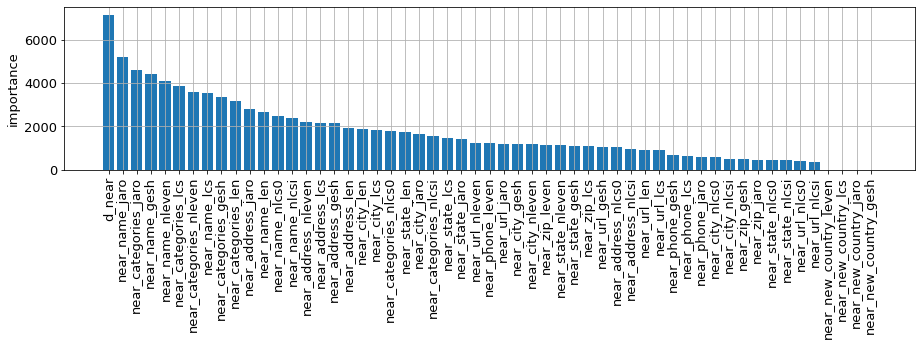

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-14 04:54:31,001] A new study created in memory with name: no-name-18f2cbdf-049c-45e3-9ae8-a9adc9176d55


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.776301, precision: 0.874559, recall: 0.883831


[I 2022-05-14 04:55:46,497] Trial 0 finished with value: 0.7763006661542609 and parameters: {'threshold': 0.1345033957845373}. Best is trial 0 with value: 0.7763006661542609.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 04:56:49,160] Trial 1 finished with value: 0.8214209839210167 and parameters: {'threshold': 0.5083062317158824}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.821421, precision: 0.962602, recall: 0.853345


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 04:57:27,552] Trial 2 finished with value: 0.6728316438900495 and parameters: {'threshold': 0.99820676130328}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.672832, precision: 0.999895, recall: 0.672916


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.795981, precision: 0.991123, recall: 0.803369


[I 2022-05-14 04:58:20,548] Trial 3 finished with value: 0.795980574684985 and parameters: {'threshold': 0.8585397999653396}. Best is trial 1 with value: 0.8214209839210167.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 04:59:08,023] Trial 4 finished with value: 0.7361478066793792 and parameters: {'threshold': 0.9755914666930857}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.736148, precision: 0.998519, recall: 0.737348


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.785381, precision: 0.887716, recall: 0.881751


[I 2022-05-14 05:00:20,401] Trial 5 finished with value: 0.7853808248164239 and parameters: {'threshold': 0.15965853465063828}. Best is trial 1 with value: 0.8214209839210167.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.809445, precision: 0.985551, recall: 0.821571


[I 2022-05-14 05:01:15,683] Trial 6 finished with value: 0.8094447739615344 and parameters: {'threshold': 0.7717090041715964}. Best is trial 1 with value: 0.8214209839210167.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:02:19,492] Trial 7 finished with value: 0.8210938085767082 and parameters: {'threshold': 0.4716438465454855}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.821094, precision: 0.958390, recall: 0.856682


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:03:13,570] Trial 8 finished with value: 0.7781452778832185 and parameters: {'threshold': 0.9187376898742313}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.778145, precision: 0.994920, recall: 0.782343


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:04:14,690] Trial 9 finished with value: 0.8077291312158997 and parameters: {'threshold': 0.7868772072627076}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.807729, precision: 0.986571, recall: 0.818989


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:05:17,589] Trial 10 finished with value: 0.8210115462289225 and parameters: {'threshold': 0.46824212471812043}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.821012, precision: 0.957968, recall: 0.856970


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:06:20,556] Trial 11 finished with value: 0.821259078226948 and parameters: {'threshold': 0.48507402519370524}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.821259, precision: 0.959978, recall: 0.855475


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:07:22,526] Trial 12 finished with value: 0.8197838213278814 and parameters: {'threshold': 0.6234844060500024}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.819784, precision: 0.974100, recall: 0.841745


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:08:29,120] Trial 13 finished with value: 0.813617936314162 and parameters: {'threshold': 0.3205988789117166}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.813618, precision: 0.935343, recall: 0.869136


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:09:35,626] Trial 14 finished with value: 0.815854979016417 and parameters: {'threshold': 0.3490709858299188}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.815855, precision: 0.940579, recall: 0.866855


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.819536, precision: 0.974593, recall: 0.841076


[I 2022-05-14 05:10:33,679] Trial 15 finished with value: 0.8195359983041028 and parameters: {'threshold': 0.6291407654875597}. Best is trial 1 with value: 0.8214209839210167.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:11:34,644] Trial 16 finished with value: 0.8197952403066178 and parameters: {'threshold': 0.6229828912445587}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.819795, precision: 0.974049, recall: 0.841801


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:13:48,971] Trial 17 finished with value: 0.4274667259075025 and parameters: {'threshold': 0.0032756488716725873}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.427467, precision: 0.453037, recall: 0.900555


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:14:53,748] Trial 18 finished with value: 0.8148436992657295 and parameters: {'threshold': 0.33544859731033294}. Best is trial 1 with value: 0.8214209839210167.


CV: 0.814844, precision: 0.938127, recall: 0.867972


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821470, precision: 0.966477, recall: 0.850016


[I 2022-05-14 05:15:56,075] Trial 19 finished with value: 0.8214701392550794 and parameters: {'threshold': 0.5436774939371852}. Best is trial 19 with value: 0.8214701392550794.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:16:53,810] Trial 20 finished with value: 0.8150492911301432 and parameters: {'threshold': 0.7090466078888469}. Best is trial 19 with value: 0.8214701392550794.


CV: 0.815049, precision: 0.981063, recall: 0.831015


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:17:56,033] Trial 21 finished with value: 0.8214591177762844 and parameters: {'threshold': 0.5167504209712678}. Best is trial 19 with value: 0.8214701392550794.


CV: 0.821459, precision: 0.963548, recall: 0.852563


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821336, precision: 0.968520, recall: 0.848116


[I 2022-05-14 05:18:57,313] Trial 22 finished with value: 0.821336264223377 and parameters: {'threshold': 0.5632679615220151}. Best is trial 19 with value: 0.8214701392550794.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:20:00,901] Trial 23 finished with value: 0.8194493168465524 and parameters: {'threshold': 0.4136979381451139}. Best is trial 19 with value: 0.8214701392550794.


CV: 0.819449, precision: 0.950757, recall: 0.861657


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821429, precision: 0.966813, recall: 0.849684


[I 2022-05-14 05:21:03,481] Trial 24 finished with value: 0.8214285682179915 and parameters: {'threshold': 0.5470270563761375}. Best is trial 19 with value: 0.8214701392550794.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:22:11,322] Trial 25 finished with value: 0.803750902978374 and parameters: {'threshold': 0.2404903067641041}. Best is trial 19 with value: 0.8214701392550794.


CV: 0.803751, precision: 0.916716, recall: 0.875320


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:23:10,846] Trial 26 finished with value: 0.8148578914103705 and parameters: {'threshold': 0.7115438222338998}. Best is trial 19 with value: 0.8214701392550794.


CV: 0.814858, precision: 0.981261, recall: 0.830647


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:24:12,396] Trial 27 finished with value: 0.8213585662566798 and parameters: {'threshold': 0.5595815913488039}. Best is trial 19 with value: 0.8214701392550794.


CV: 0.821359, precision: 0.968129, recall: 0.848469


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:25:18,212] Trial 28 finished with value: 0.8188709467659709 and parameters: {'threshold': 0.4011982738922304}. Best is trial 19 with value: 0.8214701392550794.


CV: 0.818871, precision: 0.948922, recall: 0.862656


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:26:26,089] Trial 29 finished with value: 0.8065407985044682 and parameters: {'threshold': 0.2588482121534094}. Best is trial 19 with value: 0.8214701392550794.


CV: 0.806541, precision: 0.921614, recall: 0.873901


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:27:29,953] Trial 30 finished with value: 0.8213732899609323 and parameters: {'threshold': 0.5579127178600668}. Best is trial 19 with value: 0.8214701392550794.


CV: 0.821373, precision: 0.967963, recall: 0.848623


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821503, precision: 0.964425, recall: 0.851837


[I 2022-05-14 05:28:33,669] Trial 31 finished with value: 0.8215030638739964 and parameters: {'threshold': 0.5244726941002602}. Best is trial 31 with value: 0.8215030638739964.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.819581, precision: 0.951241, recall: 0.861371


[I 2022-05-14 05:29:36,833] Trial 32 finished with value: 0.8195809740603922 and parameters: {'threshold': 0.4172426081430224}. Best is trial 31 with value: 0.8215030638739964.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.816981, precision: 0.978877, recall: 0.834843


[I 2022-05-14 05:30:35,591] Trial 33 finished with value: 0.8169809777096817 and parameters: {'threshold': 0.6805021076999458}. Best is trial 31 with value: 0.8215030638739964.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821488, precision: 0.965553, recall: 0.850837


[I 2022-05-14 05:31:39,314] Trial 34 finished with value: 0.8214877731980424 and parameters: {'threshold': 0.5350231976123903}. Best is trial 31 with value: 0.8215030638739964.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:32:42,862] Trial 35 finished with value: 0.8214179871773494 and parameters: {'threshold': 0.5128896475016854}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.821418, precision: 0.963104, recall: 0.852910


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:33:42,189] Trial 36 finished with value: 0.8184784560398276 and parameters: {'threshold': 0.652197792125675}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.818478, precision: 0.976515, recall: 0.838356


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:34:38,682] Trial 37 finished with value: 0.8096707353120906 and parameters: {'threshold': 0.7694959532999548}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.809671, precision: 0.985390, recall: 0.821931


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:35:45,211] Trial 38 finished with value: 0.820322107677497 and parameters: {'threshold': 0.43858128201797936}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.820322, precision: 0.954159, recall: 0.859570


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:36:47,335] Trial 39 finished with value: 0.8210712943844746 and parameters: {'threshold': 0.5770411495991454}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.821071, precision: 0.969841, recall: 0.846708


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:37:54,953] Trial 40 finished with value: 0.8169503643400233 and parameters: {'threshold': 0.3656784758053759}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.816950, precision: 0.943416, recall: 0.865503


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:38:58,192] Trial 41 finished with value: 0.8214628091688252 and parameters: {'threshold': 0.5187109897063222}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.821463, precision: 0.963763, recall: 0.852381


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:39:59,531] Trial 42 finished with value: 0.8214326915331172 and parameters: {'threshold': 0.5067867093723575}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.821433, precision: 0.962455, recall: 0.853489


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821414, precision: 0.962782, recall: 0.853184


[I 2022-05-14 05:41:03,503] Trial 43 finished with value: 0.8214139949741066 and parameters: {'threshold': 0.5098592269133995}. Best is trial 31 with value: 0.8215030638739964.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.820498, precision: 0.971879, recall: 0.844373


[I 2022-05-14 05:42:06,419] Trial 44 finished with value: 0.8204977568050501 and parameters: {'threshold': 0.599230879973597}. Best is trial 31 with value: 0.8215030638739964.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.820722, precision: 0.956055, recall: 0.858332


[I 2022-05-14 05:43:10,170] Trial 45 finished with value: 0.8207215277500414 and parameters: {'threshold': 0.4532017368713299}. Best is trial 31 with value: 0.8215030638739964.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821472, precision: 0.964083, recall: 0.852106


[I 2022-05-14 05:44:13,333] Trial 46 finished with value: 0.8214719406073587 and parameters: {'threshold': 0.5214521036668004}. Best is trial 31 with value: 0.8215030638739964.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:45:22,151] Trial 47 finished with value: 0.810734763420003 and parameters: {'threshold': 0.2918783196238081}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.810735, precision: 0.929477, recall: 0.871307


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.817359, precision: 0.978353, recall: 0.835666


[I 2022-05-14 05:46:22,566] Trial 48 finished with value: 0.8173593931917462 and parameters: {'threshold': 0.6739406766357511}. Best is trial 31 with value: 0.8215030638739964.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:47:21,728] Trial 49 finished with value: 0.7981103428812578 and parameters: {'threshold': 0.8479827741767058}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.798110, precision: 0.990515, recall: 0.806008


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821032, precision: 0.958047, recall: 0.856927


[I 2022-05-14 05:48:27,511] Trial 50 finished with value: 0.8210315914225258 and parameters: {'threshold': 0.468840067969182}. Best is trial 31 with value: 0.8215030638739964.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:49:32,177] Trial 51 finished with value: 0.8214138033475098 and parameters: {'threshold': 0.5122040072894556}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.821414, precision: 0.963034, recall: 0.852968


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:50:34,498] Trial 52 finished with value: 0.8203892842677443 and parameters: {'threshold': 0.6024049246117953}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.820389, precision: 0.972170, recall: 0.844015


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:51:41,835] Trial 53 finished with value: 0.8180236318686225 and parameters: {'threshold': 0.3836572325739023}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.818024, precision: 0.946276, recall: 0.864098


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821481, precision: 0.965259, recall: 0.851082


[I 2022-05-14 05:52:45,594] Trial 54 finished with value: 0.8214809259340157 and parameters: {'threshold': 0.532401015465962}. Best is trial 31 with value: 0.8215030638739964.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:53:49,754] Trial 55 finished with value: 0.8209797453100977 and parameters: {'threshold': 0.4668608433006413}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.820980, precision: 0.957788, recall: 0.857090


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:54:51,003] Trial 56 finished with value: 0.8206402919872557 and parameters: {'threshold': 0.5937309363181368}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.820640, precision: 0.971397, recall: 0.844931


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:55:54,374] Trial 57 finished with value: 0.821472599822956 and parameters: {'threshold': 0.5442658924822582}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.821473, precision: 0.966539, recall: 0.849965


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:56:55,720] Trial 58 finished with value: 0.8186658903028705 and parameters: {'threshold': 0.6490549628327846}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.818666, precision: 0.976286, recall: 0.838737


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:57:57,909] Trial 59 finished with value: 0.8150065518606908 and parameters: {'threshold': 0.7095249019192907}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.815007, precision: 0.981102, recall: 0.830938


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 05:58:53,905] Trial 60 finished with value: 0.8116878192531306 and parameters: {'threshold': 0.7491348530927014}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.811688, precision: 0.983993, recall: 0.825142


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:00:01,385] Trial 61 finished with value: 0.8213801061848733 and parameters: {'threshold': 0.5519730012149271}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.821380, precision: 0.967310, recall: 0.849203


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:01:07,026] Trial 62 finished with value: 0.8214567399205912 and parameters: {'threshold': 0.5313833232823866}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.821457, precision: 0.965133, recall: 0.851172


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:02:15,104] Trial 63 finished with value: 0.819913437310154 and parameters: {'threshold': 0.6190908106148416}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.819913, precision: 0.973713, recall: 0.842206


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:03:24,946] Trial 64 finished with value: 0.8202332593818471 and parameters: {'threshold': 0.43503317636137845}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.820233, precision: 0.953705, recall: 0.859879


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:04:46,568] Trial 65 finished with value: 0.8209448227622568 and parameters: {'threshold': 0.5813599616866577}. Best is trial 31 with value: 0.8215030638739964.


CV: 0.820945, precision: 0.970228, recall: 0.846249


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:06:07,268] Trial 66 finished with value: 0.8215036630719393 and parameters: {'threshold': 0.5375345852449337}. Best is trial 66 with value: 0.8215036630719393.


CV: 0.821504, precision: 0.965829, recall: 0.850617


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:07:30,451] Trial 67 finished with value: 0.8212608407899084 and parameters: {'threshold': 0.4852206956002527}. Best is trial 66 with value: 0.8215036630719393.


CV: 0.821261, precision: 0.960000, recall: 0.855457


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:09:04,448] Trial 68 finished with value: 0.7369802953595278 and parameters: {'threshold': 0.07109454881614208}. Best is trial 66 with value: 0.8215036630719393.


CV: 0.736980, precision: 0.820428, recall: 0.889961


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821453, precision: 0.966649, recall: 0.849849


[I 2022-05-14 06:10:24,091] Trial 69 finished with value: 0.8214531751232172 and parameters: {'threshold': 0.5453712918540478}. Best is trial 66 with value: 0.8215036630719393.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:11:34,637] Trial 70 finished with value: 0.8212610843833277 and parameters: {'threshold': 0.487521291081381}. Best is trial 66 with value: 0.8215036630719393.


CV: 0.821261, precision: 0.960266, recall: 0.855230


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:12:40,276] Trial 71 finished with value: 0.8214883481173527 and parameters: {'threshold': 0.5289107886586895}. Best is trial 66 with value: 0.8215036630719393.


CV: 0.821488, precision: 0.964878, recall: 0.851423


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:13:40,445] Trial 72 finished with value: 0.8191263960896079 and parameters: {'threshold': 0.639571191103446}. Best is trial 66 with value: 0.8215036630719393.


CV: 0.819126, precision: 0.975505, recall: 0.839872


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:14:46,365] Trial 73 finished with value: 0.8215062056532476 and parameters: {'threshold': 0.5374837130812122}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821506, precision: 0.965823, recall: 0.850625


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:15:51,847] Trial 74 finished with value: 0.8203176525073134 and parameters: {'threshold': 0.43790198603888886}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.820318, precision: 0.954083, recall: 0.859631


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:16:58,223] Trial 75 finished with value: 0.8210711313072626 and parameters: {'threshold': 0.5770609896512867}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821071, precision: 0.969843, recall: 0.846707


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.819030, precision: 0.949444, recall: 0.862378


[I 2022-05-14 06:18:04,492] Trial 76 finished with value: 0.8190303726543416 and parameters: {'threshold': 0.4048704323653262}. Best is trial 73 with value: 0.8215062056532476.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821338, precision: 0.960889, recall: 0.854767


[I 2022-05-14 06:19:08,728] Trial 77 finished with value: 0.8213384623555193 and parameters: {'threshold': 0.49273196436243716}. Best is trial 73 with value: 0.8215062056532476.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821500, precision: 0.965794, recall: 0.850643


[I 2022-05-14 06:20:11,989] Trial 78 finished with value: 0.8214995827646959 and parameters: {'threshold': 0.5372123954529401}. Best is trial 73 with value: 0.8215062056532476.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821436, precision: 0.966754, recall: 0.849741


[I 2022-05-14 06:21:23,307] Trial 79 finished with value: 0.8214363759770982 and parameters: {'threshold': 0.5464264177580925}. Best is trial 73 with value: 0.8215062056532476.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:22:26,053] Trial 80 finished with value: 0.8177898879885172 and parameters: {'threshold': 0.6667227123274725}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.817790, precision: 0.977772, recall: 0.836589


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:23:33,141] Trial 81 finished with value: 0.8215025021116009 and parameters: {'threshold': 0.5379642782264042}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821503, precision: 0.965872, recall: 0.850579


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:24:34,536] Trial 82 finished with value: 0.8203263804323762 and parameters: {'threshold': 0.6058658906994935}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.820326, precision: 0.972492, recall: 0.843669


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:25:37,525] Trial 83 finished with value: 0.8211902398599668 and parameters: {'threshold': 0.572624487565283}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821190, precision: 0.969457, recall: 0.847165


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:26:43,017] Trial 84 finished with value: 0.8207595149910095 and parameters: {'threshold': 0.45517940017158026}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.820760, precision: 0.956295, recall: 0.858164


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:27:45,820] Trial 85 finished with value: 0.8215008933659297 and parameters: {'threshold': 0.5373516506433277}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821501, precision: 0.965809, recall: 0.850630


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:28:47,499] Trial 86 finished with value: 0.8199208368224871 and parameters: {'threshold': 0.6188480015487133}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.819921, precision: 0.973688, recall: 0.842236


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:29:52,946] Trial 87 finished with value: 0.8213440519976253 and parameters: {'threshold': 0.4973929863851861}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821344, precision: 0.961399, recall: 0.854324


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:30:57,285] Trial 88 finished with value: 0.821501520942027 and parameters: {'threshold': 0.5242536448219424}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821502, precision: 0.964395, recall: 0.851860


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821151, precision: 0.958959, recall: 0.856254


[I 2022-05-14 06:32:00,324] Trial 89 finished with value: 0.8211510710957386 and parameters: {'threshold': 0.4763141199439238}. Best is trial 73 with value: 0.8215062056532476.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:33:05,904] Trial 90 finished with value: 0.8197349071581148 and parameters: {'threshold': 0.4223286148268626}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.819735, precision: 0.951952, recall: 0.860909


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:34:08,805] Trial 91 finished with value: 0.8214775510632054 and parameters: {'threshold': 0.5301829454939452}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821478, precision: 0.965021, recall: 0.851293


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:35:13,013] Trial 92 finished with value: 0.8212063373969464 and parameters: {'threshold': 0.5720522403301067}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821206, precision: 0.969411, recall: 0.847222


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:36:16,385] Trial 93 finished with value: 0.8214883806687121 and parameters: {'threshold': 0.5351489156944098}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821488, precision: 0.965570, recall: 0.850822


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:37:18,341] Trial 94 finished with value: 0.8205641897280583 and parameters: {'threshold': 0.5965021892412523}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.820564, precision: 0.971638, recall: 0.844648


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:38:26,617] Trial 95 finished with value: 0.8207903825950164 and parameters: {'threshold': 0.4557579889231772}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.820790, precision: 0.956381, recall: 0.858124


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:39:32,032] Trial 96 finished with value: 0.8213671228145202 and parameters: {'threshold': 0.4999488393421303}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821367, precision: 0.961680, recall: 0.854099


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.821502, precision: 0.964393, recall: 0.851864


[I 2022-05-14 06:40:36,387] Trial 97 finished with value: 0.8215024134981831 and parameters: {'threshold': 0.5242137258297094}. Best is trial 73 with value: 0.8215062056532476.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:41:41,129] Trial 98 finished with value: 0.8214321596451148 and parameters: {'threshold': 0.5142934801958436}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.821432, precision: 0.963271, recall: 0.852782


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-14 06:42:47,962] Trial 99 finished with value: 0.818035444898738 and parameters: {'threshold': 0.38408943755316616}. Best is trial 73 with value: 0.8215062056532476.


CV: 0.818035, precision: 0.946330, recall: 0.864064


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5374837130812122

In [ ]:
study.best_value

0.8215062056532476

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

# Submit

In [ ]:
test["pred"] = pred[:, 1]

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[test["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()